In [ ]:
# Step 1: Installing required packages
!pip install pandas numpy matplotlib seaborn plotly wordcloud nltk textblob scikit-learn

# Step 2: Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud

# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab') # Added this line to download the missing resource

# Machine learning for topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

print("All packages imported successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


All packages imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Step 3: Loading the data
df = pd.read_csv('Copy of Umuzi XB1 Check in (Responses) - Form Responses 1.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully!
Dataset shape: (372, 8)


In [ ]:
# Step 4: Initial data exploration
print("=== DATABASE OVERVIEW ===")
print(f"Total records: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print("\nColumn names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

print("\nFirst 3 rows:")
print(df.head(3))

print("\nMissing values per column:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

=== DATABASE OVERVIEW ===
Total records: 372
Number of columns: 8

Column names:
1. Timestamp
2. Column 2
3. Full name
4. Please enter the date today
5. Share a win from the last week (what went well, something you enjoyed)
6. Share a loss (something that was challenging or did not go well)
7. Share a blocker, if any (anything that stopped you from doing what you needed to do)
8. Anything else you would like to share or ask

First 3 rows:
           Timestamp  Column 2  Full name Please enter the date today  \
0  7/9/2025 14:34:49       NaN  Student 1                    7/9/2025   
1  7/9/2025 14:43:15       NaN  Student 2                    7/9/2025   
2  7/9/2025 14:49:40       NaN  Student 3                    7/9/2025   

  Share a win from the last week (what went well, something you enjoyed)  \
0  Completing my first week with Umuzi gave me co...                       
1  I enjoyed introspecting myself on the basis of...                       
2  Submitting all my work in time an

In [ ]:
# Step 5: Data cleaning and preprocessing

df_clean.columns = ['timestamp', 'column2', 'full_name', 'date_today', 'win', 'loss', 'blocker', 'additional_comments']

print("Columns renamed for analysis:")
for col in df_clean.columns:
    print(f"- {col}")

# Display sample data from our key analysis columns
print("\n=== SAMPLE DATA FROM KEY COLUMNS ===")
print("WINS (first 5 non-null entries):")
print(df_clean['win'].dropna().head(5).to_string())
print("\nLOSSES (first 5 non-null entries):")
print(df_clean['loss'].dropna().head(5).to_string())
print("\nBLOCKERS (first 5 non-null entries):")
print(df_clean['blocker'].dropna().head(5).to_string())

Columns renamed for analysis:
- timestamp
- column2
- full_name
- date_today
- win
- loss
- blocker
- additional_comments

=== SAMPLE DATA FROM KEY COLUMNS ===
WINS (first 5 non-null entries):
0    Completing my first week with Umuzi gave me co...
1    I enjoyed introspecting myself on the basis of...
2    Submitting all my work in time and completing ...
3         I submitted most of the assigned assignments
4    I enjoyed the Life Lifeline activity. I got to...

LOSSES (first 5 non-null entries):
0    I didn’t get opportunities from two companies ...
1    Except for being sick and experiencing challen...
2                                    I don’t have any 
3    I did not understand some assignments s well a...
6    I would say I struggled a bit or was confused ...

BLOCKERS (first 5 non-null entries):
0    Being financially unstable has been draining m...
1    None, only temporary set backs (reception and ...
2    Data , I couldn’t join some meetings because I...
3    Spending most

In [ ]:
# Step 6: Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

# Apply preprocessing to our key columns
print("Preprocessing text data...")
df_clean['win_clean'] = df_clean['win'].apply(preprocess_text)
df_clean['loss_clean'] = df_clean['loss'].apply(preprocess_text)
df_clean['blocker_clean'] = df_clean['blocker'].apply(preprocess_text)

print("Text preprocessing completed!")
print(f"Sample preprocessed win: {df_clean['win_clean'].iloc[0]}")

Preprocessing text data...
Text preprocessing completed!
Sample preprocessed win: completing first week umuzi gave confidence sense purpose especially enjoyed design thinking odyssey plan exercise helped plan commit effectively


In [ ]:
# Step 7: Basic statistics and response analysis
print("=== RESPONSE ANALYSIS ===")
total_students = len(df_clean)
win_responses = df_clean['win'].notna().sum()
loss_responses = df_clean['loss'].notna().sum()
blocker_responses = df_clean['blocker'].notna().sum()

print(f"Total students: {total_students}")
print(f"Win responses: {win_responses} ({win_responses/total_students*100:.1f}%)")
print(f"Loss responses: {loss_responses} ({loss_responses/total_students*100:.1f}%)")
print(f"Blocker responses: {blocker_responses} ({blocker_responses/total_students*100:.1f}%)")

# Response length analysis
df_clean['win_length'] = df_clean['win_clean'].str.split().str.len()
df_clean['loss_length'] = df_clean['loss_clean'].str.split().str.len()
df_clean['blocker_length'] = df_clean['blocker_clean'].str.split().str.len()

print("\nAverage response length (words):")
print(f"Wins: {df_clean['win_length'].mean():.1f}")
print(f"Losses: {df_clean['loss_length'].mean():.1f}")
print(f"Blockers: {df_clean['blocker_length'].mean():.1f}")

=== RESPONSE ANALYSIS ===
Total students: 372
Win responses: 360 (96.8%)
Loss responses: 304 (81.7%)
Blocker responses: 279 (75.0%)

Average response length (words):
Wins: 8.3
Losses: 6.3
Blockers: 4.7


In [ ]:
# Step 8: Sentiment Analysis
def analyze_sentiment(text):
    if pd.isna(text) or text == "":
        return 0
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

print("Performing sentiment analysis...")
# Apply sentiment analysis
df_clean['win_sentiment'] = df_clean['win'].apply(analyze_sentiment)
df_clean['loss_sentiment'] = df_clean['loss'].apply(analyze_sentiment)
df_clean['blocker_sentiment'] = df_clean['blocker'].apply(analyze_sentiment)

print("Sentiment analysis completed!")

# Sentiment statistics
print("\n=== SENTIMENT ANALYSIS RESULTS ===")
sentiment_stats = pd.DataFrame({
    'Wins': df_clean['win_sentiment'].describe(),
    'Losses': df_clean['loss_sentiment'].describe(),
    'Blockers': df_clean['blocker_sentiment'].describe()
})
print(sentiment_stats)

Performing sentiment analysis...
Sentiment analysis completed!

=== SENTIMENT ANALYSIS RESULTS ===
             Wins      Losses    Blockers
count  372.000000  372.000000  372.000000
mean     0.214195    0.034958   -0.006203
std      0.232572    0.233468    0.197745
min     -0.700000   -0.812143   -1.000000
25%      0.000000    0.000000    0.000000
50%      0.200000    0.000000    0.000000
75%      0.400000    0.088542    0.000000
max      0.900000    1.000000    0.800000


In [ ]:
# Step 10: Word Frequency Analysis
def get_top_words(text_series, n=15):
    all_words = ' '.join(text_series.dropna()).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

# Top words for each category
print("Analyzing word frequencies...")
top_win_words = get_top_words(df_clean['win_clean'])
top_loss_words = get_top_words(df_clean['loss_clean'])
top_blocker_words = get_top_words(df_clean['blocker_clean'])

print("=== TOP WORDS ANALYSIS ===")
print("\nTop 15 Win Words:")
for i, (word, freq) in enumerate(top_win_words, 1):
    print(f"{i:2d}. {word:15} : {freq:3d} occurrences")

print("\nTop 15 Loss Words:")
for i, (word, freq) in enumerate(top_loss_words, 1):
    print(f"{i:2d}. {word:15} : {freq:3d} occurrences")

print("\nTop 15 Blocker Words:")
for i, (word, freq) in enumerate(top_blocker_words, 1):
    print(f"{i:2d}. {word:15} : {freq:3d} occurrences")

Analyzing word frequencies...
=== TOP WORDS ANALYSIS ===

Top 15 Win Words:
 1. enjoyed         :  90 occurrences
 2. week            :  50 occurrences
 3. course          :  45 occurrences
 4. learning        :  40 occurrences
 5. life            :  39 occurrences
 6. time            :  39 occurrences
 7. really          :  38 occurrences
 8. plan            :  36 occurrences
 9. managed         :  36 occurrences
10. task            :  30 occurrences
11. got             :  28 occurrences
12. able            :  28 occurrences
13. well            :  27 occurrences
14. completed       :  26 occurrences
15. work            :  25 occurrences

Top 15 Loss Words:
 1. time            :  64 occurrences
 2. week            :  37 occurrences
 3. work            :  35 occurrences
 4. everything      :  24 occurrences
 5. able            :  22 occurrences
 6. challenging     :  22 occurrences
 7. challenge       :  21 occurrences
 8. could           :  21 occurrences
 9. bit             :  20 occu

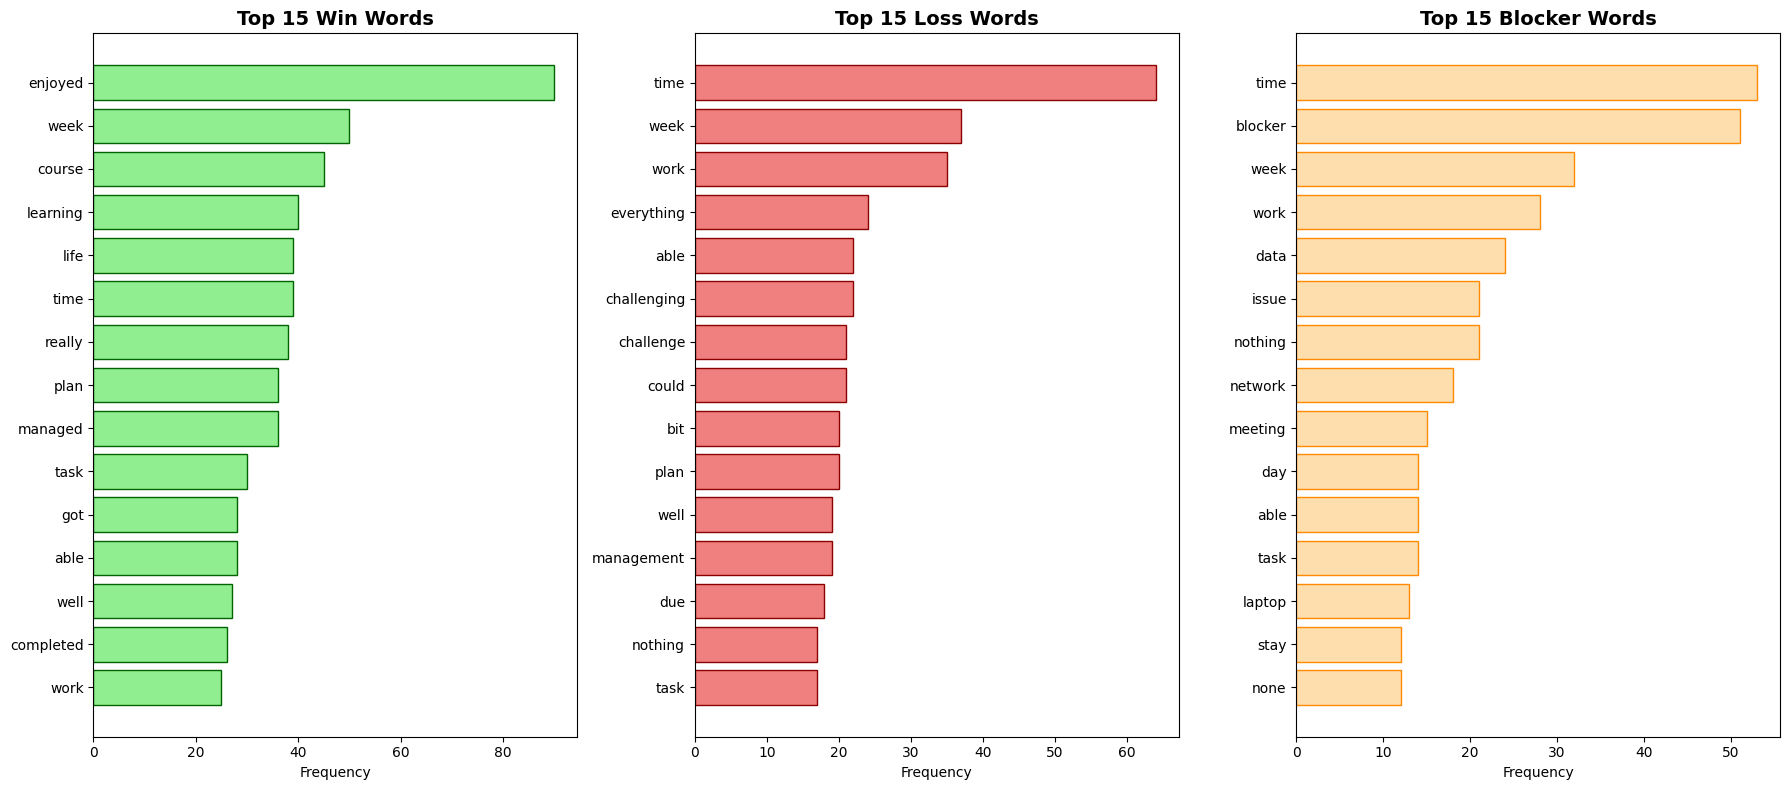

In [ ]:
# Step 11: Visualization - Top Words
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Win words
win_words, win_freqs = zip(*top_win_words)
axes[0].barh(range(len(win_words)), win_freqs, color='lightgreen', edgecolor='darkgreen')
axes[0].set_yticks(range(len(win_words)))
axes[0].set_yticklabels(win_words)
axes[0].set_title('Top 15 Win Words', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Loss words
loss_words, loss_freqs = zip(*top_loss_words)
axes[1].barh(range(len(loss_words)), loss_freqs, color='lightcoral', edgecolor='darkred')
axes[1].set_yticks(range(len(loss_words)))
axes[1].set_yticklabels(loss_words)
axes[1].set_title('Top 15 Loss Words', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

# Blocker words
blocker_words, blocker_freqs = zip(*top_blocker_words)
axes[2].barh(range(len(blocker_words)), blocker_freqs, color='navajowhite', edgecolor='darkorange')
axes[2].set_yticks(range(len(blocker_words)))
axes[2].set_yticklabels(blocker_words)
axes[2].set_title('Top 15 Blocker Words', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Frequency')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

=== WORD CLOUDS ===


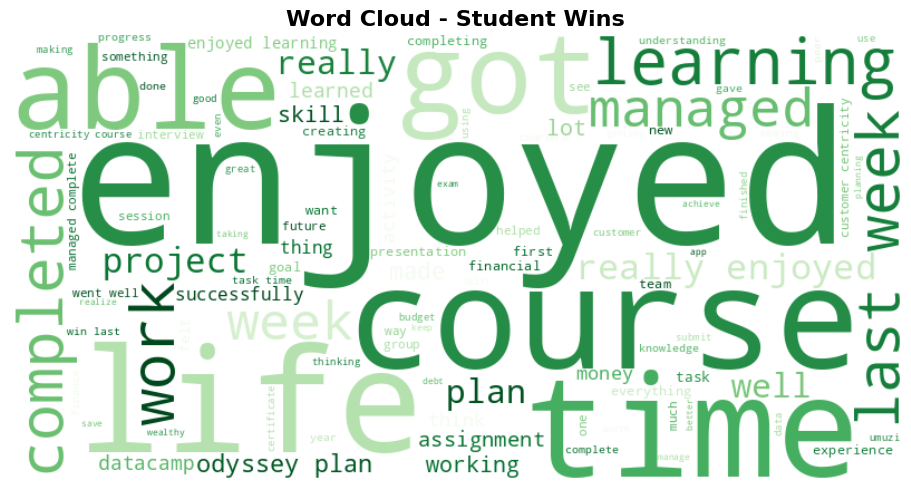

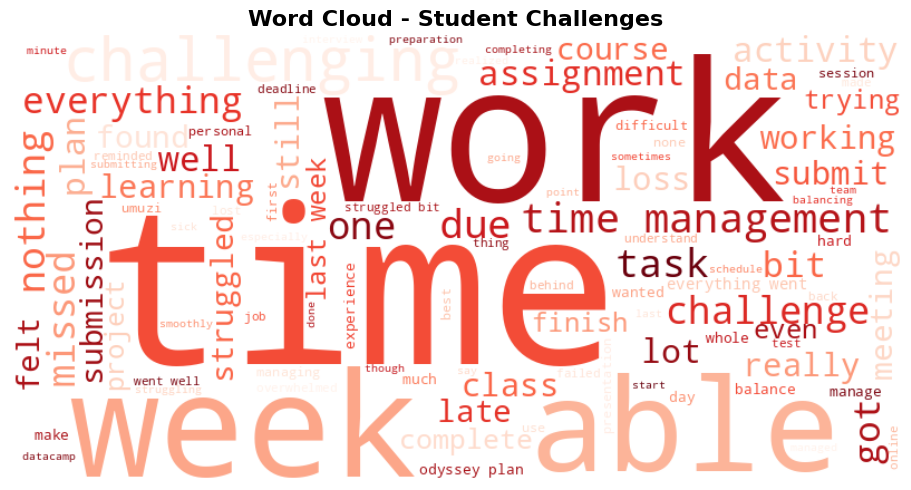

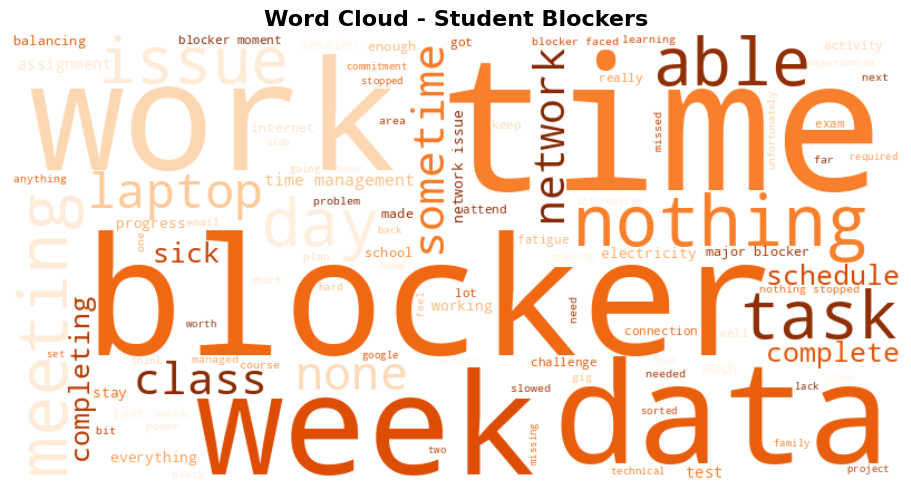

In [ ]:
# Step 12: Word Clouds
def create_wordcloud(text, title, color):
    if text.dropna().empty:
        print(f"No data for {title}")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        max_words=100,
        contour_width=1,
        contour_color='steelblue'
    ).generate(' '.join(text.dropna()))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("=== WORD CLOUDS ===")
create_wordcloud(df_clean['win_clean'], 'Word Cloud - Student Wins', 'Greens')
create_wordcloud(df_clean['loss_clean'], 'Word Cloud - Student Challenges', 'Reds')
create_wordcloud(df_clean['blocker_clean'], 'Word Cloud - Student Blockers', 'Oranges')

In [ ]:
# Step 13: Theme Categorization Analysis
def categorize_themes(text_series, category_name):
    themes = {
        'technical_issues': ['data', 'network', 'internet', 'connection', 'wifi', 'laptop', 'computer', 'power', 'electricity', 'loadshedding', 'technical'],
        'time_management': ['time', 'management', 'schedule', 'deadline', 'balance', 'rushing', 'overwhelmed', 'busy', 'rushed'],
        'financial': ['money', 'financial', 'data', 'fund', 'budget', 'debt', 'wealth', 'financ', 'cash'],
        'personal_health': ['sick', 'illness', 'flu', 'health', 'fatigue', 'tired', 'exhausted', 'mental', 'hospital'],
        'family_responsibilities': ['family', 'child', 'baby', 'kids', 'mother', 'parent', 'responsibility', 'children'],
        'academic_workload': ['assignment', 'course', 'study', 'exam', 'test', 'school', 'university', 'academic', 'class'],
        'emotional_mental': ['stress', 'anxiety', 'overwhelmed', 'confidence', 'mental', 'emotional', 'burnout', 'depress', 'anxious'],
        'learning_progress': ['learn', 'understand', 'complete', 'finished', 'progress', 'achievement', 'certificate', 'skill'],
        'career_development': ['job', 'career', 'interview', 'work', 'employment', 'professional', 'opportunity']
    }

    theme_counts = {theme: 0 for theme in themes.keys()}
    total_responses = text_series.notna().sum()

    for text in text_series.dropna():
        text_lower = str(text).lower()
        for theme, keywords in themes.items():
            if any(keyword in text_lower for keyword in keywords):
                theme_counts[theme] += 1

    # Convert to percentages
    theme_percentages = {theme: (count/total_responses)*100 if total_responses > 0 else 0
                        for theme, count in theme_counts.items()}

    return theme_percentages

print("=== THEME CATEGORIZATION ANALYSIS ===")

# Analyze themes for each category
win_themes = categorize_themes(df_clean['win'], 'Wins')
loss_themes = categorize_themes(df_clean['loss'], 'Losses')
blocker_themes = categorize_themes(df_clean['blocker'], 'Blockers')

print("\nTheme Distribution (% of responses containing theme):")
print("\nWINS - What students are celebrating:")
for theme, percentage in sorted(win_themes.items(), key=lambda x: x[1], reverse=True):
    if percentage > 1:  # Only show themes with >1% occurrence
        print(f"  • {theme.replace('_', ' ').title()}: {percentage:.1f}%")

print("\nLOSSES - Where students struggle:")
for theme, percentage in sorted(loss_themes.items(), key=lambda x: x[1], reverse=True):
    if percentage > 1:
        print(f"  • {theme.replace('_', ' ').title()}: {percentage:.1f}%")

print("\nBLOCKERS - What stops student progress:")
for theme, percentage in sorted(blocker_themes.items(), key=lambda x: x[1], reverse=True):
    if percentage > 1:
        print(f"  • {theme.replace('_', ' ').title()}: {percentage:.1f}%")

=== THEME CATEGORIZATION ANALYSIS ===

Theme Distribution (% of responses containing theme):

WINS - What students are celebrating:
  • Learning Progress: 36.4%
  • Academic Workload: 22.2%
  • Career Development: 17.8%
  • Financial: 15.3%
  • Time Management: 14.2%
  • Technical Issues: 8.9%
  • Family Responsibilities: 2.5%
  • Emotional Mental: 2.5%
  • Personal Health: 1.9%

LOSSES - Where students struggle:
  • Time Management: 26.0%
  • Academic Workload: 20.4%
  • Career Development: 19.1%
  • Learning Progress: 12.5%
  • Technical Issues: 11.2%
  • Financial: 8.6%
  • Emotional Mental: 4.6%
  • Personal Health: 2.6%
  • Family Responsibilities: 1.3%

BLOCKERS - What stops student progress:
  • Technical Issues: 29.4%
  • Time Management: 24.0%
  • Career Development: 19.0%
  • Academic Workload: 17.9%
  • Financial: 11.5%
  • Personal Health: 9.7%
  • Learning Progress: 8.2%
  • Emotional Mental: 3.9%
  • Family Responsibilities: 2.5%


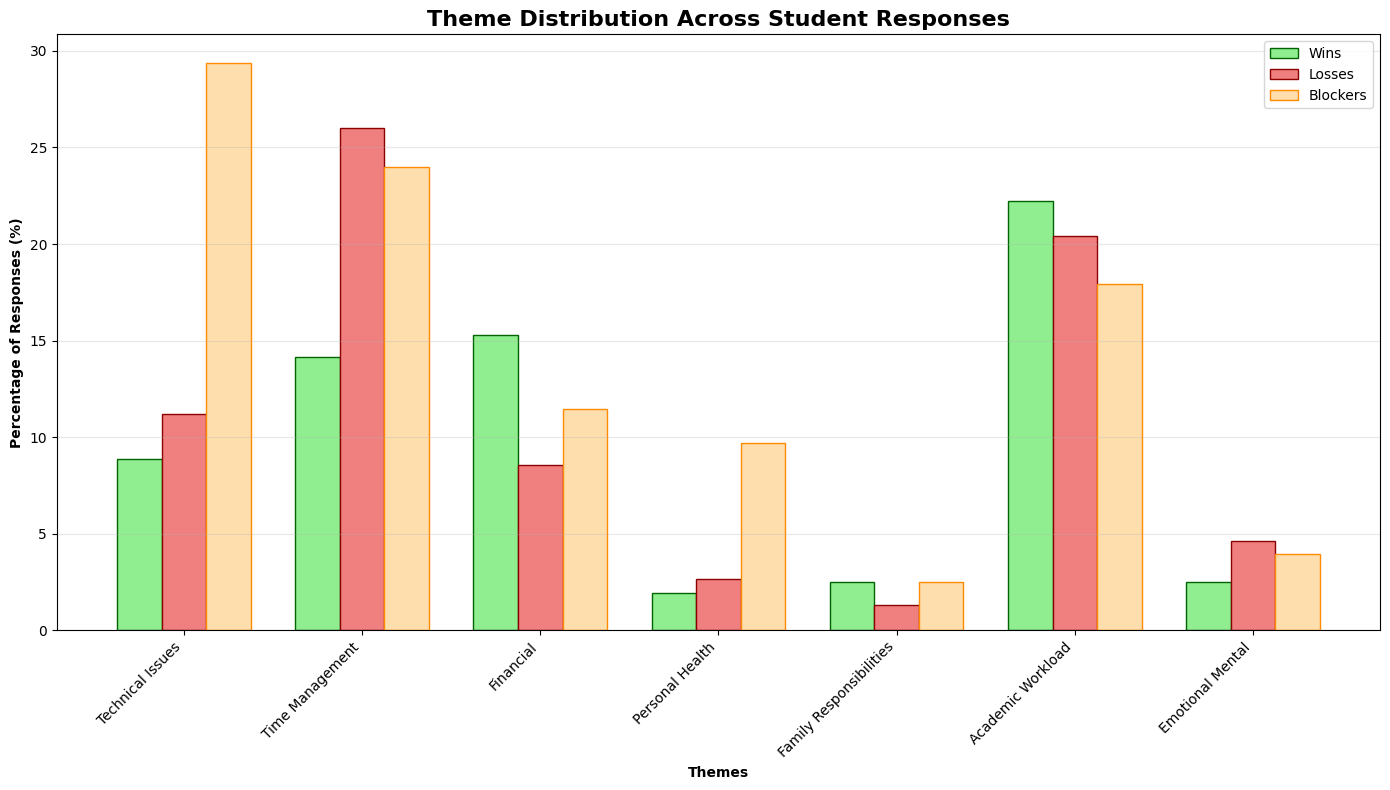

In [ ]:
# Step 14: Visualization - Theme Analysis
# Prepare data for visualization
themes_to_plot = ['technical_issues', 'time_management', 'financial', 'personal_health',
                  'family_responsibilities', 'academic_workload', 'emotional_mental']

win_values = [win_themes[theme] for theme in themes_to_plot]
loss_values = [loss_themes[theme] for theme in themes_to_plot]
blocker_values = [blocker_themes[theme] for theme in themes_to_plot]

theme_names = [theme.replace('_', ' ').title() for theme in themes_to_plot]

x = np.arange(len(theme_names))
width = 0.25

plt.figure(figsize=(14, 8))
plt.bar(x - width, win_values, width, label='Wins', color='lightgreen', edgecolor='darkgreen')
plt.bar(x, loss_values, width, label='Losses', color='lightcoral', edgecolor='darkred')
plt.bar(x + width, blocker_values, width, label='Blockers', color='navajowhite', edgecolor='darkorange')

plt.xlabel('Themes', fontweight='bold')
plt.ylabel('Percentage of Responses (%)', fontweight='bold')
plt.title('Theme Distribution Across Student Responses', fontsize=16, fontweight='bold')
plt.xticks(x, theme_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Step 15: Comprehensive Insights and Recommendations
print("="*70)
print("COMPREHENSIVE NLP ANALYSIS - KEY FINDINGS & RECOMMENDATIONS")
print("="*70)

# Calculate key metrics
total_students = len(df_clean)
response_rates = {
    'wins': df_clean['win'].notna().sum() / total_students * 100,
    'losses': df_clean['loss'].notna().sum() / total_students * 100,
    'blockers': df_clean['blocker'].notna().sum() / total_students * 100
}

avg_sentiments = {
    'wins': df_clean['win_sentiment'].mean(),
    'losses': df_clean['loss_sentiment'].mean(),
    'blockers': df_clean['blocker_sentiment'].mean()
}

print(f"\n QUANTITATIVE OVERVIEW:")
print(f"   • Total Students: {total_students}")
print(f"   • Response Rates: Wins {response_rates['wins']:.1f}%, Losses {response_rates['losses']:.1f}%, Blockers {response_rates['blockers']:.1f}%")
print(f"   • Average Sentiment: Wins {avg_sentiments['wins']:.3f}, Losses {avg_sentiments['losses']:.3f}, Blockers {avg_sentiments['blockers']:.3f}")

print(f"\n TOP STUDENT SUCCESS FACTORS (Wins):")
top_win_themes = [k for k, v in sorted(win_themes.items(), key=lambda x: x[1], reverse=True) if v > 5][:3]
for theme in top_win_themes:
    print(f"   • {theme.replace('_', ' ').title()}: {win_themes[theme]:.1f}% of students mention this positively")

print(f"\n CRITICAL CHALLENGES (Losses & Blockers):")
top_challenge_themes = [k for k, v in sorted(loss_themes.items(), key=lambda x: x[1], reverse=True) if v > 5][:3]
for theme in top_challenge_themes:
    loss_pct = loss_themes[theme]
    blocker_pct = blocker_themes.get(theme, 0)
    print(f"   • {theme.replace('_', ' ').title()}: {loss_pct:.1f}% report challenges, {blocker_pct:.1f}% as blockers")

COMPREHENSIVE NLP ANALYSIS - KEY FINDINGS & RECOMMENDATIONS

 QUANTITATIVE OVERVIEW:
   • Total Students: 372
   • Response Rates: Wins 96.8%, Losses 81.7%, Blockers 75.0%
   • Average Sentiment: Wins 0.214, Losses 0.035, Blockers -0.006

 TOP STUDENT SUCCESS FACTORS (Wins):
   • Learning Progress: 36.4% of students mention this positively
   • Academic Workload: 22.2% of students mention this positively
   • Career Development: 17.8% of students mention this positively

 CRITICAL CHALLENGES (Losses & Blockers):
   • Time Management: 26.0% report challenges, 24.0% as blockers
   • Academic Workload: 20.4% report challenges, 17.9% as blockers
   • Career Development: 19.1% report challenges, 19.0% as blockers


In [ ]:
# Step 16: Generate Actionable Recommendations
print(f"\n💡 ACTIONABLE RECOMMENDATIONS FOR PROGRAM MANAGEMENT:")

# Based on the most frequent blockers
top_blockers = [k for k, v in sorted(blocker_themes.items(), key=lambda x: x[1], reverse=True) if v > 5]

print(f"\n🔴 HIGH PRIORITY - IMMEDIATE ACTIONS:")
if 'technical_issues' in top_blockers:
    print("   • Address technical infrastructure: Provide data bundles, improve platform stability")
if 'financial' in top_blockers:
    print("   • Financial support: Consider stipends, data support, or emergency funds")
if 'time_management' in top_blockers:
    print("   • Time management support: Flexible deadlines, time management workshops")

print(f"\n🟡 MEDIUM PRIORITY - PROGRAM ENHANCEMENTS:")
if 'emotional_mental' in top_blockers or 'emotional_mental' in [k for k, v in loss_themes.items() if v > 5]:
    print("   • Mental health support: Counseling services, stress management resources")
if 'family_responsibilities' in top_blockers:
    print("   • Family-friendly scheduling: Consider family obligations in program design")
if 'academic_workload' in top_blockers:
    print("   • Workload management: Review assignment volume and complexity")

print(f"\n🟢 PROACTIVE MEASURES - STUDENT SUCCESS:")
print("   • Regular check-ins: Continue with current feedback system")
print("   • Peer support: Establish mentorship or buddy systems")
print("   • Celebrate wins: Acknowledge and share student successes")
print("   • Early intervention: Identify at-risk students through sentiment trends")

print(f"\n📈 SUCCESS INDICATORS TO MONITOR:")
print("   • Positive sentiment in 'win' responses")
print("   • Decreasing technical issues over time")
print("   • Improved response rates across all categories")
print("   • Reduction in critical blockers mentioned")


💡 ACTIONABLE RECOMMENDATIONS FOR PROGRAM MANAGEMENT:

🔴 HIGH PRIORITY - IMMEDIATE ACTIONS:
   • Address technical infrastructure: Provide data bundles, improve platform stability
   • Financial support: Consider stipends, data support, or emergency funds
   • Time management support: Flexible deadlines, time management workshops

🟡 MEDIUM PRIORITY - PROGRAM ENHANCEMENTS:
   • Workload management: Review assignment volume and complexity

🟢 PROACTIVE MEASURES - STUDENT SUCCESS:
   • Regular check-ins: Continue with current feedback system
   • Peer support: Establish mentorship or buddy systems
   • Celebrate wins: Acknowledge and share student successes
   • Early intervention: Identify at-risk students through sentiment trends

📈 SUCCESS INDICATORS TO MONITOR:
   • Positive sentiment in 'win' responses
   • Decreasing technical issues over time
   • Improved response rates across all categories
   • Reduction in critical blockers mentioned


In [ ]:
# Step 17: Export Analysis Results
# Create comprehensive summary
summary_data = {
    'analysis_date': [pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')],
    'total_students': [total_students],
    'win_response_rate': [response_rates['wins']],
    'loss_response_rate': [response_rates['losses']],
    'blocker_response_rate': [response_rates['blockers']],
    'avg_win_sentiment': [avg_sentiments['wins']],
    'avg_loss_sentiment': [avg_sentiments['losses']],
    'avg_blocker_sentiment': [avg_sentiments['blockers']],
    'top_win_theme': [top_win_themes[0] if top_win_themes else 'N/A'],
    'top_challenge_theme': [top_challenge_themes[0] if top_challenge_themes else 'N/A'],
    'critical_blocker_count': [len(top_blockers)]
}

summary_df = pd.DataFrame(summary_data)

print("=== ANALYSIS SUMMARY ===")
print(summary_df.T)

# Export to CSV
summary_df.to_csv('umuzi_student_analysis_summary.csv', index=False)
print("\n✅ Analysis summary exported to 'umuzi_student_analysis_summary.csv'")

# Export detailed theme analysis
theme_analysis = pd.DataFrame({
    'theme': themes_to_plot,
    'win_percentage': [win_themes[theme] for theme in themes_to_plot],
    'loss_percentage': [loss_themes[theme] for theme in themes_to_plot],
    'blocker_percentage': [blocker_themes[theme] for theme in themes_to_plot]
})
theme_analysis.to_csv('umuzi_theme_analysis.csv', index=False)
print("✅ Theme analysis exported to 'umuzi_theme_analysis.csv'")

=== ANALYSIS SUMMARY ===
                                          0
analysis_date           2025-11-17 09:03:08
total_students                          372
win_response_rate                 96.774194
loss_response_rate                 81.72043
blocker_response_rate                  75.0
avg_win_sentiment                  0.214195
avg_loss_sentiment                 0.034958
avg_blocker_sentiment             -0.006203
top_win_theme             learning_progress
top_challenge_theme         time_management
critical_blocker_count                    7

✅ Analysis summary exported to 'umuzi_student_analysis_summary.csv'
✅ Theme analysis exported to 'umuzi_theme_analysis.csv'


In [ ]:
# Additional Export: Top Words Analysis
top_words_df = pd.DataFrame({
    'win_words': [word for word, freq in top_win_words],
    'win_frequency': [freq for word, freq in top_win_words],
    'loss_words': [word for word, freq in top_loss_words],
    'loss_frequency': [freq for word, freq in top_loss_words],
    'blocker_words': [word for word, freq in top_blocker_words],
    'blocker_frequency': [freq for word, freq in top_blocker_words]
})

top_words_df.to_csv('umuzi_top_words_analysis.csv', index=False)
print("✅ Top words analysis exported to 'umuzi_top_words_analysis.csv'")

# Additional Export: Raw Sentiment Data
sentiment_export = df_clean[['win', 'win_sentiment', 'loss', 'loss_sentiment', 'blocker', 'blocker_sentiment']].copy()
sentiment_export.to_csv('umuzi_sentiment_raw_data.csv', index=False)
print("✅ Raw sentiment data exported to 'umuzi_sentiment_raw_data.csv'")

✅ Top words analysis exported to 'umuzi_top_words_analysis.csv'
✅ Raw sentiment data exported to 'umuzi_sentiment_raw_data.csv'
